<a href="https://colab.research.google.com/github/dskimds/2nd-Prj/blob/master/10_05(ver_1)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>[개요]</center>

집값이 계속해서 오르고 있습니다! 
사람들이 가장 궁금한것은 **"어느 지역의 집값이 가장 많이 오를지"** 라고 생각합니다.  
따라서 저는 이번 시각화 대회를 통해 집값의 추이를 예측해 보았습니다.  

이때 **"집값"**은 단순히 집값이 아니라 **"월세통합가격지수"**를 의미합니다.  
즉 **집을 구매하고 월세를 받을 때 가장 큰 수익을 얻을 수 있는 지역**이 어디인지 예측하는 것입니다.  
따라서 아래에 나오는 "집값"은 월세를 의미한다고 이해하시면 됩니다.  

먼저 주택 종류별 가격 및 미분양 주택 비율을 이용하여 기본적인 EDA를 진행합니다.  
이후 지역별 아파트, 연립다세대, 단독주택의 가격을 분석하고 미래의 가격을 예측합니다.   
이를 통해 지금 집을 산다면 어느 지역에 있는 집을 사야 하는지 알아보겠습니다!  

시각화 대회의 취지에 맞게 최대한 알아보기 쉽게 정리하고 시각화 하려고 노력했습니다.  
코드를 다 보셔도 좋지만 목차를 따라서 시각화 된 부분만 보셔도 좋을것 같습니다!     

그럼 재미있게 봐주세요~  

# <center>[목차]</center>

    1. EDA  
        1.1 전처리 및 필요함수 정의  
        1.2 주택매매, 전세가격지수  
            1.2.1 주택매매가격  
            1.2.2 주택전세가격  
            1.2.3 동시 시각화  
        1.3 미분양 주택 시각화  
            1.3.1 지역별 시간에 따른 미분양 주택현황  
            1.3.2 최근 5년간 지역별 미분양주택현황 비율(년단위)  
            1.3.3 도심과 지방의 미분양주택 비율  
            1.3.4 최근 1년간 지역별 미분양주택현황 수(월단위)  
    2. 예측 모델링  
        2.1 전처리 및 필요함수 정의  
        2.2 예측 모델 학습  
            2.2.1 아파트
            2.2.2 연립다세대
            2.2.3 단독주택
    3. 예측 결과 시각화  
        3.1 전처리 및 필요 함수 정의  
        3.2 예측모델 확인 및 예측값 시각화
            3.2.1 아파트  
            3.2.2 연립다세대  
            3.2.3 단독주택  
        3.3 최대상승 예상 지역 시각화  
            3.3.1 아파트  
            3.3.2 연립다세대  
            3.3.3 단독주택  
    4. 실제 투자하기
        4.1 필요한 금액
        4.2 예상 수익
    5. 결론 및 한계

# 1. EDA

In [14]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import pickle
import os

import matplotlib as mat
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import font_manager as fm
# print('위치:', mat.matplotlib_fname())
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
plt.rcParams['font.family'] = "Malgun Gothic"
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 1.1 전처리 및 필요함수 정의

In [15]:
def df_to_line_graph(df,tit):
    # 한글깨짐 방지
    rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = "Malgun Gothic"
    
    # 캔버스생성
    fig = plt.figure(figsize=(15, 10)) # 캔버스 생성
    fig.set_facecolor('white') # 캔버스 색상 설정
    
    # 그림 뼈대(프레임) 생성
    ax = fig.add_subplot() 
    ax.set_xlabel("날짜")
    ax.set_ylabel("2019-01-01이 100일때")
    
    # x축 눈금설정
    size=len(df)
    a=size//12
    ax.set_xticks([12*i for i in range(a)]) 
    
    # 데이터추가
    cols=df.columns
    for col in cols:
        ax.plot(df[col],label=col) ## 선그래프 생성

    plt.legend() #범례
    plt.xticks(rotation=90) # x축 각도회전
    plt.title(tit,fontsize=20) # 타이틀설정
    
    plt.grid()
    
    plt.show()
    
    
def L_to_pie(L,cols,t):        
    plt.title(t) #타이틀
    plt.pie(L, labels=cols, autopct='%.0f%%') #설정
    plt.show()
    
def returnName(s):
    indx=s.index("[")
    return s[:indx]

def cumulate_bar(df):
    exceptL=["전국[호]","수도권[호]"]
    cols=[col for col in df.columns if col not in exceptL]

    size=len(cols)
    lastSize=12

    a=[np.array(df[col][-1*lastSize:]) for col in cols]

    # 캔버스생성
    fig = plt.figure(figsize=(20, 10))
    
    # x축생성
    X=df.index[-1*lastSize:] 
    
    myBar=[]
    # 막대그리기
    myBar.append(plt.bar(X,a[0]))
    for i in range(1,size):
        myBar.append(plt.bar(X,a[i],bottom=sum(a[:i])))
    
    # 기타
    ax = fig.add_subplot() 
    ax.set_xlabel("날짜",fontsize=18)
    ax.set_ylabel("미분양주택(호)",fontsize=18)
    plt.title("최근 1년간 미분양주택현황",fontsize=25)

    cols=list(map(returnName,cols))
    plt.legend(myBar,cols)
    plt.show()
    
def df_to_pie(df,d):
    cols=df.columns
    exceptL=["전국[호]","수도권[호]"]
    
    cols=[col for col in df.columns if col not in exceptL]
    ratio=df.loc[d,cols]
    labels=list(map(returnName,cols))
    size=len(ratio)
    
    explode=[0.15 for i in range(size)]
        
    plt.title(d+" 미분양주택현황") #타이틀
    plt.pie(ratio, labels=labels, autopct='%.0f%%', explode=explode) #설정
    plt.show()

## 1.2 주택매매, 전세 가격지수

날짜별 주택매매 및 전세 가격지수를 알아보겠습니다.  
각각의 값은 각지역의 2019년 1월 집값을 100이라고 할 때의 상대값을 나타냅니다.

### 1.2.1 주택매매가격

In [16]:
house_price=pd.read_csv("주택매매가격지수(KB).csv")
house_price.set_index("Unnamed: 0",inplace=True)
house_price_df=house_price.iloc[:,:4]
house_price_df.columns=["총지수","단독주택","연립주택","아파트"]

display(house_price_df)

,총지수,단독주택,연립주택,아파트
Unnamed: 0,,,,
1986-01-01,34.656,61.347,43.053,20.973
1986-02-01,34.656,61.347,42.925,20.973
1986-03-01,34.708,61.513,42.733,20.935
1986-04-01,34.449,61.097,42.733,20.819
1986-05-01,34.293,60.848,41.837,20.664
...,...,...,...,...
2021-05-01,115.133,106.557,110.434,118.017
2021-06-01,116.642,106.586,110.672,120.246
2021-07-01,118.002,106.973,111.323,122.073


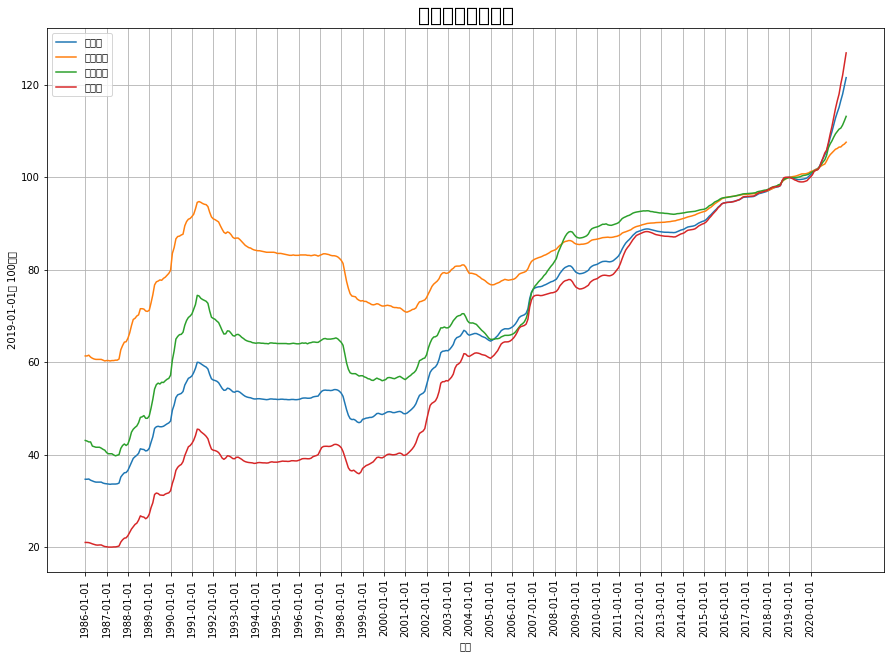

In [17]:
df_to_line_graph(house_price_df,"주택매매가격지수")

전체적으로 우상향 하는 경항이 있습니다. 집값은 계속 오르고 있었습니다.  
2015년 까지는 단독주택, 연립주택, 아파트 순으로 가격이 높았지만 이후 아파트의 가격이 급격히 상승합니다.

### 1.2.2 주택전세가격

In [ ]:
jonse_price=pd.read_csv("주택전세가격지수(KB).csv")
jonse_price.set_index("Unnamed: 0",inplace=True)
jonse_price_df=house_price.iloc[:,:4]
jonse_price_df.columns=["총지수","단독주택","연립주택","아파트"]

display(jonse_price_df)

,총지수,단독주택,연립주택,아파트
Unnamed: 0,,,,
1986-01-01,34.656,61.347,43.053,20.973
1986-02-01,34.656,61.347,42.925,20.973
1986-03-01,34.708,61.513,42.733,20.935
1986-04-01,34.449,61.097,42.733,20.819
1986-05-01,34.293,60.848,41.837,20.664
...,...,...,...,...
2020-11-01,107.125,104.334,106.398,107.506
2020-12-01,108.586,104.909,107.237,109.346
2021-01-01,109.878,105.303,107.895,111.005


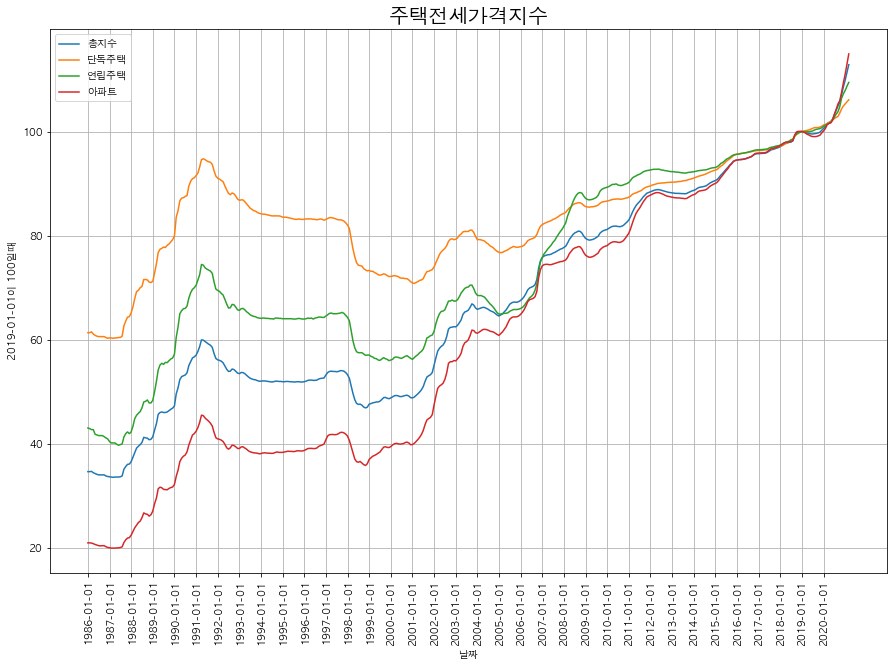

In [ ]:
df_to_line_graph(jonse_price_df,"주택전세가격지수")

전세가격역시 매매가격과 거의 유사합니다. 대략 2015년까지 단독주택의 가격이 상대적으로 가장 높다가 이후 아파트의 상대가격이 가장 높아집니다.

### 1.2.3 동시 시각화
주택매매가격과 주택전세가격을 동시에 시각화해 보겠습니다.

In [ ]:
house_price_df.columns=["총지수","단독주택","연립주택","아파트"]
jonse_price_df.columns=["총지수(전세)","단독주택(전세)","연립주택(전세)","아파트(전세)"]
total_df=pd.concat([house_price_df,jonse_price_df],axis=1)

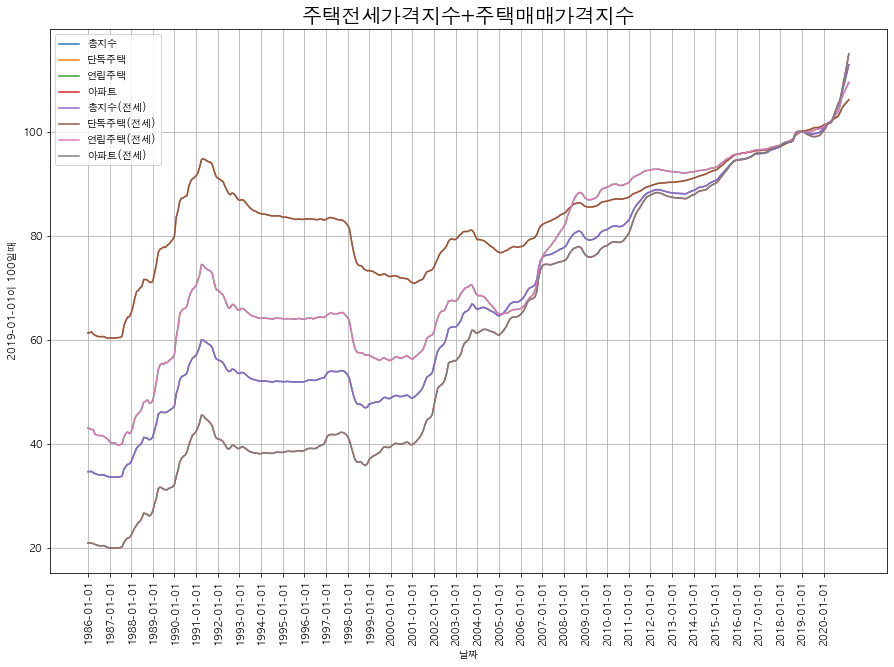

In [ ]:
df_to_line_graph(total_df,"주택전세가격지수+주택매매가격지수")

실제로 매매와 전세를 비교해보니 거의 정확히 일치합니다.  
8개의 선을 그렸지만 정확히 겹쳐지면서 4개의 선으로 보입니다.  
즉 전세가격과 매매가격은 항상 같은 증감폭을 보이는것을 알 수 있습니다.

## 1.3 미분양주택현황 시각화

### 1.3.1 지역별 시간에 따른 미분양 주택현황
시간에 따라서 지역별 미분양 주택현황이 어떻게 변화하는지 알아보겠습니다

In [ ]:
unsold_df=pd.read_csv("미분양주택현황.csv")
unsold_df.set_index("Unnamed: 0",inplace=True)

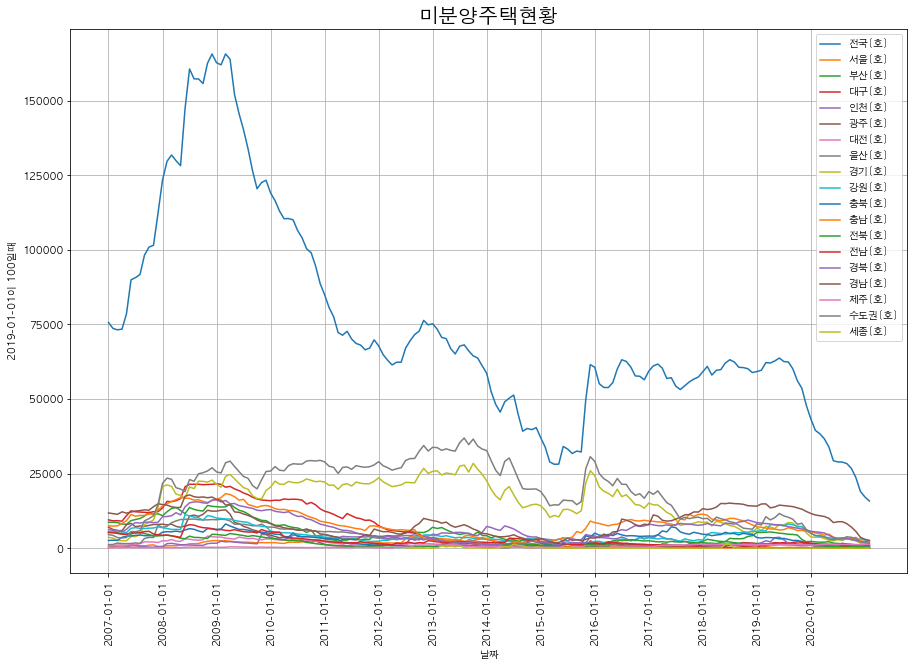

In [ ]:
df_to_line_graph(unsold_df,"미분양주택현황")

In [ ]:
unsold_df

,전국[호],서울[호],부산[호],대구[호],인천[호],광주[호],대전[호],울산[호],경기[호],강원[호],충북[호],충남[호],전북[호],전남[호],경북[호],경남[호],제주[호],수도권[호],세종[호]
Unnamed: 0,,,,,,,,,,,,,,,,,,,
2007-01-01,75616.0,697.0,8680.0,9467.0,243.0,7005.0,819.0,1180.0,3604.0,5312.0,2548.0,7449.0,5179.0,5374.0,6210.0,11772.0,77.0,4544.0,NaN
2007-02-01,73619.0,590.0,8653.0,9134.0,312.0,6246.0,803.0,1210.0,3361.0,5344.0,2645.0,7363.0,5098.0,5253.0,5948.0,11563.0,96.0,4263.0,NaN
2007-03-01,73162.0,687.0,8548.0,9189.0,266.0,5905.0,1048.0,1687.0,2579.0,5801.0,2565.0,7446.0,5184.0,4887.0,5854.0,11328.0,188.0,3532.0,NaN
2007-04-01,73393.0,685.0,8074.0,9009.0,219.0,5829.0,1020.0,1521.0,2488.0,5460.0,3632.0,8250.0,4812.0,4664.0,5419.0,12149.0,162.0,3392.0,NaN
2007-05-01,78571.0,704.0,7964.0,10888.0,362.0,7842.0,957.0,1500.0,2488.0,5212.0,4012.0,9195.0,4625.0,4640.0,6303.0,11723.0,156.0,3554.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,26703.0,52.0,1262.0,1143.0,822.0,245.0,832.0,474.0,2733.0,2884.0,307.0,3235.0,444.0,1073.0,2922.0,7042.0,1233.0,3607.0,0.0
2020-11-01,23620.0,52.0,1084.0,667.0,691.0,88.0,831.0,473.0,2440.0,2648.0,275.0,3582.0,400.0,1059.0,2541.0,5581.0,1208.0,3183.0,0.0
2020-12-01,19005.0,49.0,973.0,280.0,466.0,31.0,638.0,468.0,1616.0,3115.0,273.0,2510.0,661.0,1059.0,2154.0,3617.0,1095.0,2131.0,0.0


### 1.3.2 최근 5년간 지역별 미분양주택현황 비율(년단위)
최근 5년 지역별 미분양주택의 비율을 파이차트로 나타내 보았습니다.

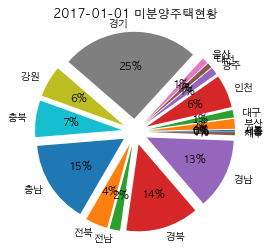

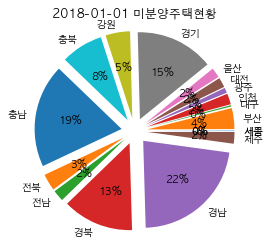

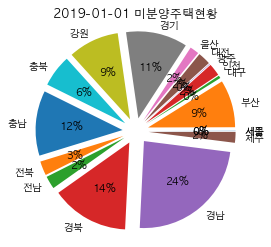

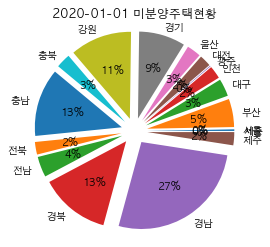

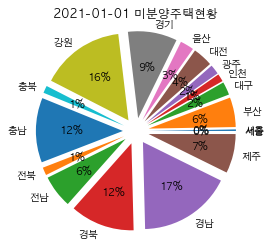

In [ ]:
for i in range(5):
    year=2017+i
    df_to_pie(unsold_df.loc[[str(year)+"-01-01"]],str(year)+"-01-01")

5년간의 미분양주택현황 추이를 보면 경남,경북의 미분양주택 비율이 높아지고 경기의 비율이 크게 낮아진 것을 볼 수 있습니다.  

또한 전체적으로 도단위로 표시된 지방의 미분양주택비율이 경기도 및 광역시들에 비해 큽니다. 

이를 파이차트로 나타내면 아래와 같습니다.

### 1.3.3 도심과 지방의 미분양주택 비율

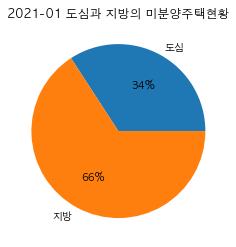

In [ ]:
cityL=["서울","부산","대구","인천","광주","대전","울산","경기","세종","제주"]
countryL=["강원","충북","충남","전북","전남","경북","경남"]

L=[sum([unsold_df.iloc[-2][col+"[호]"] for col in cityL]),sum([unsold_df.iloc[-2][col+"[호]"] for col in countryL])]

L_to_pie(L,["도심","지방"],"2021-01 도심과 지방의 미분양주택현황")

지방의 미분양주택이 도심의 미분양주택에 비해 약 두배정도 많은 것을 알 수 있습니다.  
지방의 주택은 도심에 비해 두배정도 더 비어있는 것입니다.  

### 1.3.4 최근 1년간 지역별 미분양주택현황 수(월단위)

그렇다면 최근 1년의 월단위 추이는 어떨까요?  
누적막대그래프를 이용하여 전체 미분양주택수의 크기변화와 지역별 분포를 함께 알아보겠습니다.

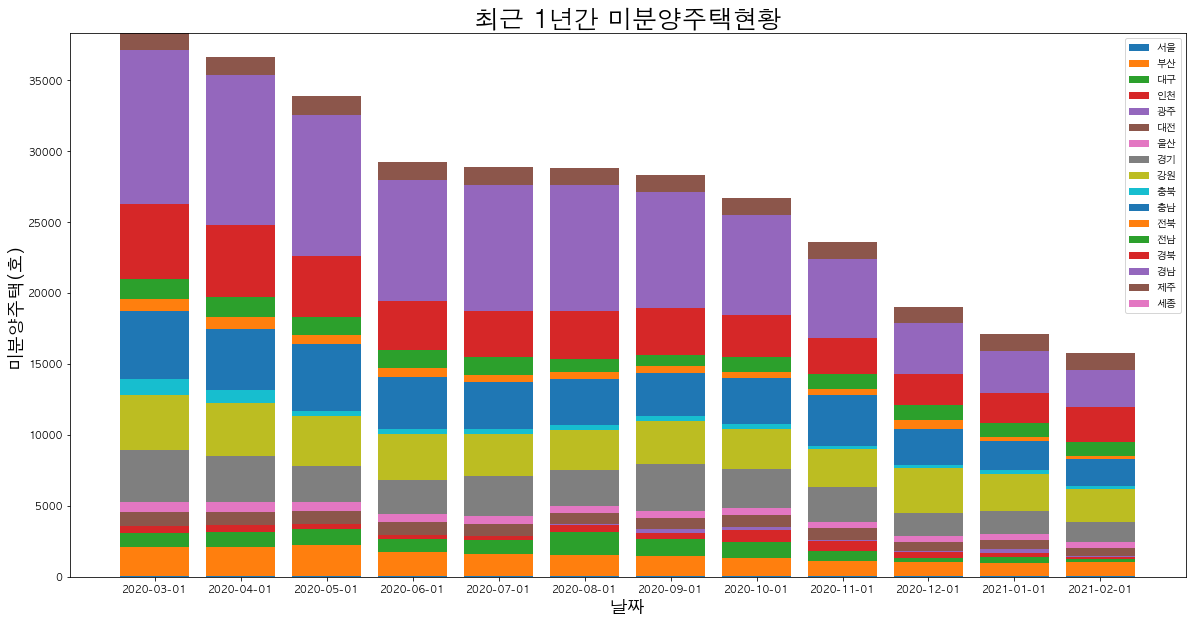

In [ ]:
cumulate_bar(unsold_df)

최근1년간의 미분양주택의 수는 점차 감소하고있습니다. 1년전에 비해 거의 절반수준으로 줄었습니다.     
지역별 비율은 파이차트에 비해 정확히 비교할 수 없겠지만 대략적으로 비슷하게 가는 것으로 보입니다.

# 2. 예측 모델링

In [ ]:
# 모델링은 코랩환경에서 진행했습니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# bagging
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# deep learning
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU

## 2.1 전처리 및 필요함수 정의

In [ ]:
# 데이터 다운
path="/gdrive/My Drive/Colab Notebooks/dacon/real_estate"
L=[]

regional_flunc=pd.read_csv(path+"/지역별_지가변동률.csv")
price_jonse=pd.read_csv(path+"/주택전세가격지수(KB).csv")
price_sell=pd.read_csv(path+"/주택매매가격지수(KB).csv")
type_monthly=pd.read_csv(path+"/유형별_주택월세통합가격지수.csv")
apart=pd.read_csv(path+"/아파트 실거래가격지수.csv")

L.extend([regional_flunc,price_jonse,price_sell,type_monthly,apart])

In [ ]:
# 필요함수 정의

# 퍼센트값을 숫자값으로
def percent_to_num(df):
    col=df.columns[0]
    numCol=col[:2]
    
    if numCol=="세종":
        startIndx=90
    else:
        startIndx=0

    size=len(df)
    num_df=pd.DataFrame(columns=["indx",numCol])
    num=1

    for i in range(startIndx,size):
        nextNum=num*(1+df[col][i]/100)
        num_df=num_df.append({"indx":df.index[i],numCol:nextNum},ignore_index=True)
        num=nextNum

    num_df.set_index("indx",inplace=True)

    return num_df


def preprocess_to_array(df):
    sequence=7
    size=len(df)
    x=[]
    y=[]
    
    myL=list(np.array(df).flatten())

    for s in range(size-sequence):
        x.append(np.array(myL[s:s+sequence]))
        y.append(myL[s+sequence])


    x=np.array(x)
    y=np.array(y)

    return x,y
    
# 직전 7개의 데이터로 미래의 데이터를 예측 할 수 있도록 전처리
def preprocess_to_df(df):
    sequence=7
    size=len(df)
    x=[]
    y=[]
    
    myL=list(np.array(df).flatten())

    for s in range(size-sequence):
        x.append(np.array(myL[s:s+sequence]))
        y.append(myL[s+sequence])

    df_x=pd.DataFrame(columns=[str(i) for i in range(sequence)])
    df_y=pd.DataFrame(columns=[str(sequence)])

    for j in range(size-sequence):
        df_x=df_x.append({str(k):x[j][k] for k in range(sequence)},ignore_index=True)
        df_y=df_y.append({str(sequence):y[j]},ignore_index=True)

    return df_x,df_y

# 회귀분석
def regression(x,y,predictSize):
    ensemble_pred=np.array([0 for i in range(predictSize)],dtype=float)
    models=[LinearRegression,Ridge]
    modelSize=len(models)

    size=len(x)
    
    cut=int(size*0.7)
    x_train,x_val=x[:cut],x[cut:]
    y_train,y_val=y[:cut],y[cut:]

    error=0
    for model in models:
        
        print(model)

        # val 확인
        my_model = model().fit(x_train, y_train)
        y_val_pred=my_model.predict(x_val)
        error+=mean_squared_error(y_val,y_val_pred)
        
        # train
        my_model = model().fit(x , y)

        sequence=7
        x_pred=[y[-1*sequence:]]
        predL=[]
        for i in range(predictSize):
            # 예측
            try:
                y_pred=my_model.predict(x_pred)[0][0]    
            except:
                y_pred=my_model.predict(x_pred)[0]

            predL.append(y_pred)
            
            # x값 조정
            x_pred=[list(x_pred[0][1:])+[y_pred]]
        
        ensemble_pred+=np.array(predL)

    return error/modelSize, ensemble_pred/modelSize

# 머신러닝(배깅, 부스팅)
def machineLearning(x,y,predictSize):
    ensemble_pred=np.array([0 for i in range(predictSize)],dtype=float)
    models=[DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor,XGBRegressor]
    modelSize=len(models)

    size=len(x)
    
    cut=int(size*0.7)
    x_train,x_val=x[:cut],x[cut:]
    y_train,y_val=y[:cut],y[cut:]
    
    error=0

    for model in models:
        
        print(model)
        # val 확인
        my_model = model().fit(x_train, y_train)
        y_val_pred=my_model.predict(x_val)
        error+=mean_squared_error(y_val,y_val_pred)
        
        # train
        my_model = model().fit(x , y )

        sequence=7
        x_pred=[y[-1*sequence:]]
        predL=[]
        for i in range(predictSize):
            # 예측
            try:
                y_pred=my_model.predict(x_pred)[0][0]    
            except:
                y_pred=my_model.predict(x_pred)[0]

            predL.append(y_pred)
            
            # x값 조정
            x_pred=[list(x_pred[0][1:])+[y_pred]]
        
        ensemble_pred+=np.array(predL)

    return error/modelSize, ensemble_pred/modelSize

# 딥러닝
def deepLearning(x,y,predictSize):
    ensemble_pred=np.array([0 for i in range(predictSize)],dtype=float)
    models=[LSTM,SimpleRNN,GRU]

    modelSize=len(models)

    size=len(x)
    
    error=0

    for model_dl in models:
        print(model_dl)
        #parameter
        sequence=7
        dropout=0.3
        epoch=300
        batch_size=14
        verbose=0

        newX=x.reshape(x.shape[0],x.shape[1],1)
        newY=y.reshape(y.shape[0],1)

        model = Sequential()
        model.add(model_dl(128, input_shape=(newX.shape[1], newX.shape[2]), activation='relu', return_sequences=True))
        model.add(Dropout(dropout)) 
        model.add(model_dl(64, activation="relu", return_sequences=False))
        model.add(Dropout(dropout)) 
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        hist = model.fit(newX, newY, batch_size=batch_size, epochs=epoch, verbose=verbose)

        error+=hist.history["loss"][0]
        predL=[]

        # predict
        tempX=np.concatenate((newX[-1][1:],np.array([newY[-1]])),axis=0)
        for i in range(predictSize):
            tempY = model.predict(np.array([tempX]))
            predL.append(tempY[0][0])
            tempX=np.concatenate((tempX[1:],tempY),axis=0)
            
        ensemble_pred+=np.array(predL)

    return error/modelSize, ensemble_pred/modelSize

#스케일링
def scaling(df):
    scaler=preprocessing.MinMaxScaler()
    
    scaler_fit=scaler.fit(df)

    result=scaler_fit.transform(df)

    df.loc[:,:] = result
    return df

## 2.2 예측 모델 학습

- 아파트, 연립다세대, 단독주택의 미래 가격을 예측합니다.  
- 직전 7달의 데이터를 가지고 그 다음 달 가격을 예측합니다
- 모델은 크게 3가지 회귀분석, 머신러닝, 딥러닝 으로 나뉩니다.
  - 회귀분석 : 선형회귀분석, 릿지
  - 머신러닝 : 의사결정나무, 랜덤포레스트, LGBM, XBG
  - 딥러닝  : GRU, LSTM, simpleRNN 
- 각각의 분석 기법별로 앙상블 모델 3개를 만듭니다. (회귀분석앙상블, 머신러닝앙상블, 딥러닝앙상블)
- 3개의 앙상블 모델 중 validation set의 loss(MSE)가 가장 낮은 모델을 선택해 미래의 가격을 예측합니다
- 예측은 2021년 4월에서 2022년 1월까지 진행합니다.


### 2.2.1 아파트

In [ ]:
# 아파트
type_monthly=pd.read_csv(path+"/유형별_주택월세통합가격지수.csv")

#스케일링
indxC=type_monthly[["Unnamed: 0"]]
type_monthly=scaling(type_monthly.iloc[:,1:])
type_monthly=pd.concat((indxC,type_monthly),axis=1)

cols=type_monthly.columns[30:47] #아파트
predictNum=12

# 최종df
indx=type_monthly.columns[0]
addedDf=pd.DataFrame({indx:["2021-02-01","2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01",
                            "2021-08-01","2021-09-01","2021-10-01","2021-11-01","2021-12-01","2022-01-01"]})
type_df=pd.concat((type_monthly[[indx]],addedDf))

total_error_df=pd.DataFrame({"지역":[],"regression":[],"machineLearning":[],"deepLearning":[]})


for col in cols:
    print(col)
    nowType=type_monthly[[col]] 

    startNameIndx=col.index("-")+1
    nowType.columns=[col[startNameIndx:startNameIndx+2]]

    df_x,df_y=preprocess_to_df(nowType)
    x,y=preprocess_to_array(nowType)

    minError=100
    error_df={"regression":[],"machineLearning":[],"deepLearning":[]}

    for j,ensemble in enumerate([regression,machineLearning,deepLearning]):
        err,ensemL=ensemble(x,y,predictNum)
        error_df[list(error_df.keys())[j]].append(err)
        if err<minError:
            final_pred=ensemL

    error_df["지역"]=[col[startNameIndx:startNameIndx+2]]
    error_df=pd.DataFrame(error_df)
    total_error_df=pd.concat((total_error_df,error_df))

    #예측값 합치기
    addedDf=pd.DataFrame({col[startNameIndx:startNameIndx+2]:final_pred})
    nowType=pd.concat((nowType,addedDf))

    #최종 데이터프레임 합치기
    type_df=pd.concat([type_df,nowType],axis=1)

total_error_df.set_index("지역",inplace=True)
total_error_df.to_csv(path+"/test/아파트_error.csv")

type_df.set_index(indx,inplace=True)
type_df.to_csv(path+"/test/아파트.csv") # 아파트

### 2.2.2 연립다세대

In [ ]:
# 연립다세대
type_monthly=pd.read_csv(path+"/유형별_주택월세통합가격지수.csv")
cols=type_monthly.columns[54:71] #연립다세대
predictNum=12

#스케일링
indxC=type_monthly[["Unnamed: 0"]]
type_monthly=scaling(type_monthly.iloc[:,1:])
type_monthly=pd.concat((indxC,type_monthly),axis=1)

# 최종df
indx=type_monthly.columns[0]
addedDf=pd.DataFrame({indx:["2021-02-01","2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01",
                            "2021-08-01","2021-09-01","2021-10-01","2021-11-01","2021-12-01","2022-01-01"]})
type_df=pd.concat((type_monthly[[indx]],addedDf))

total_error_df=pd.DataFrame({"지역":[],"regression":[],"machineLearning":[],"deepLearning":[]})

for col in cols:
    print(col)
    nowType=type_monthly[[col]] 

    startNameIndx=col.index("-")+1
    nowType.columns=[col[startNameIndx:startNameIndx+2]]

    df_x,df_y=preprocess_to_df(nowType)
    x,y=preprocess_to_array(nowType)

    minError=100
    error_df={"regression":[],"machineLearning":[],"deepLearning":[]}

    for j,ensemble in enumerate([regression,machineLearning,deepLearning]):
        err,ensemL=ensemble(x,y,predictNum)
        error_df[list(error_df.keys())[j]].append(err)
        if err<minError:
            final_pred=ensemL

    error_df["지역"]=[col[startNameIndx:startNameIndx+2]]
    error_df=pd.DataFrame(error_df)
    total_error_df=pd.concat((total_error_df,error_df))

    #예측값 합치기
    addedDf=pd.DataFrame({col[startNameIndx:startNameIndx+2]:final_pred})
    nowType=pd.concat((nowType,addedDf))

    #최종 데이터프레임 합치기
    type_df=pd.concat([type_df,nowType],axis=1)

total_error_df.set_index("지역",inplace=True)
total_error_df.to_csv(path+"/test/연립다세대_error.csv")

type_df.set_index(indx,inplace=True)
type_df.to_csv(path+"/test/연립다세대.csv")

### 2.2.3 단독주택

In [ ]:
# 단독주택
type_monthly=pd.read_csv(path+"/유형별_주택월세통합가격지수.csv")
cols=type_monthly.columns[78:95] #단독주택
predictNum=12

#스케일링
indxC=type_monthly[["Unnamed: 0"]]
type_monthly=scaling(type_monthly.iloc[:,1:])
type_monthly=pd.concat((indxC,type_monthly),axis=1)

# 최종df
indx=type_monthly.columns[0]
addedDf=pd.DataFrame({indx:["2021-02-01","2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01",
                            "2021-08-01","2021-09-01","2021-10-01","2021-11-01","2021-12-01","2022-01-01"]})
type_df=pd.concat((type_monthly[[indx]],addedDf))

total_error_df=pd.DataFrame({"지역":[],"regression":[],"machineLearning":[],"deepLearning":[]})

for col in cols:
    print(col)
    nowType=type_monthly[[col]] 

    startNameIndx=col.index("-")+1
    nowType.columns=[col[startNameIndx:startNameIndx+2]]

    df_x,df_y=preprocess_to_df(nowType)
    x,y=preprocess_to_array(nowType)

    minError=100
    error_df={"regression":[],"machineLearning":[],"deepLearning":[]}

    for j,ensemble in enumerate([regression,machineLearning,deepLearning]):
        err,ensemL=ensemble(x,y,predictNum)
        error_df[list(error_df.keys())[j]].append(err)
        if err<minError:
            final_pred=ensemL

    error_df["지역"]=[col[startNameIndx:startNameIndx+2]]
    error_df=pd.DataFrame(error_df)
    total_error_df=pd.concat((total_error_df,error_df))

    #예측값 합치기
    addedDf=pd.DataFrame({col[startNameIndx:startNameIndx+2]:final_pred})
    nowType=pd.concat((nowType,addedDf))

    #최종 데이터프레임 합치기
    type_df=pd.concat([type_df,nowType],axis=1)

total_error_df.set_index("지역",inplace=True)
total_error_df.to_csv(path+"/test/단독주택_error.csv")

type_df.set_index(indx,inplace=True)
type_df.to_csv(path+"/test/단독주택.csv")

# 3. 예측 결과 시각화

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import warnings
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import rc

warnings.filterwarnings(action='ignore')

## 3.1 전처리 및 필요 함수 정의

In [ ]:
# 라인그래프
def df_to_line_graph(df,tit,y_t):
    # 한글깨짐 방지
    rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False

    # 캔버스생성
    fig = plt.figure(figsize=(30, 10)) # 캔버스 생성
    fig.set_facecolor('white') # 캔버스 색상 설정
    
    # 그림 뼈대(프레임) 생성
    ax = fig.add_subplot() 
    ax.set_xlabel("날짜",fontsize=20)
    ax.set_ylabel(y_t,fontsize=20)
    
    # x축 눈금설정
    size=len(df)
    a=size//12
    ax.set_xticks([size-i for i in range(10,-1,-1)]) 
    
    # 데이터추가
    cols=df.columns
    for col in cols:
        ax.plot(df[col],label=col) ## 선그래프 생성

    plt.legend(fontsize=10) #범례
    plt.xticks(rotation=90) # x축 각도회전
    plt.title(tit,fontsize=35) # 타이틀설정
    
    plt.grid()
    
    plt.show()
    
# 막대그래프
def to_bar_chart(x_tick,x_bar,t):
    maxBar=max(x_bar)
    maxIndx=x_bar.index(maxBar)
    minBar=min(x_bar)
    minIndx=x_bar.index(minBar)
    
    fig = plt.figure(figsize=(15, 10))
    size=len(x_tick)
    x = np.arange(size)
    
    plt.bar(x_tick, x_bar)
    
    plt.title(t,fontsize=20)
    
    plt.axhline(y=1, color='black', linewidth=1)
    
    ax = fig.add_subplot() 
    ax.set_xlabel("지역",fontsize=13)
    ax.set_ylabel("2020년 5월 대비 ",fontsize=13)
    
    for i,val in enumerate(x_tick):
        if i==maxIndx:
            color="red"
        elif i==minIndx:
            color="brown"
        else:
            color="black"
        plt.text(val, x_bar[i], round(x_bar[i],3),
                 fontsize = 12, 
                 color=color,
                 horizontalalignment='center',
                 verticalalignment='bottom')
        
#     plt.text(x_tick[maxIndx],x_bar[maxIndx],"max point",color="red")
    
    plt.ylim([minBar-0.3, maxBar+0.3]) 
    
    plt.show()

In [ ]:
# 데이터 불러오기
apart=pd.read_csv("test/아파트.csv")
alliance=pd.read_csv("test/연립다세대.csv")
home=pd.read_csv("test/단독주택.csv")

L=[apart,alliance,home]
titles=["아파트","연립다세대","단독주택"]

apart.set_index("Unnamed: 0",inplace=True)
alliance.set_index("Unnamed: 0",inplace=True)
home.set_index("Unnamed: 0",inplace=True)

In [ ]:
# 중복날짜 제거
typeL=[]
for d in L:
    d=pd.concat((d[:-12],d[-10:]))
    typeL.append(d)

In [ ]:
# 2020년 5월 1일을 1로 정규화
for d in typeL:
    cols=d.columns #df이름

    for col in cols:
        d[col]=d[col]/d.iloc[-9][col] #5월 1일(9)

## 3.2 예측모델 확인 및 예측값 시각화
모델별 loss와 선택된 모델로 예측한 지역별 가격을 시각화합니다.  
- 2015년 6월 1일 ~ 2021년 3월 1일 까지의 값을 학습합니다.
- 2021년 4월 1일 ~ 2022년 1월 1일 구간의 집값을 예측합니다.
- 아파트, 연립다세대, 단독주택 세가지 유형을 분석합니다.
- 예측값을 2021년 5월 1일의 값으로 나누었습니다. 즉 예측값은 지금 가격(1) 대비 미래의 가격을 의미합니다.

### 3.2.1 아파트

In [ ]:
apart_error=pd.read_csv("test/아파트_error.csv")
apart_error

,지역,regression,machineLearning,deepLearning
0,서울,0.022502,0.063491,0.147232
1,경기,0.027719,0.108188,0.288707
2,인천,0.024601,0.048013,0.077052
3,부산,0.024094,0.087444,0.340756
4,대구,0.034176,0.107667,0.092612
5,광주,0.038375,0.065996,0.157401
6,대전,0.056010,0.126125,0.052047
7,울산,0.023528,0.056817,0.358142
8,세종,0.017634,0.064119,0.111210
9,강원,0.014475,0.078373,0.395283


지역별로 회귀분석 앙상블모델, 머신러닝 앙상블모델, 딥러닝 앙상블모델의 validation loss값입니다.  
세 종류의 앙상블 모델 중 loss가 가장 낮은 앙상블 모델을 이용하여 미래가격을 예측합니다.  
예들들어 서울의 경우 loss값이 가장 낮은 regression 모델로 미래가격을 예측하고, 대전의 경우 딥러닝 모델로 예측합니다.

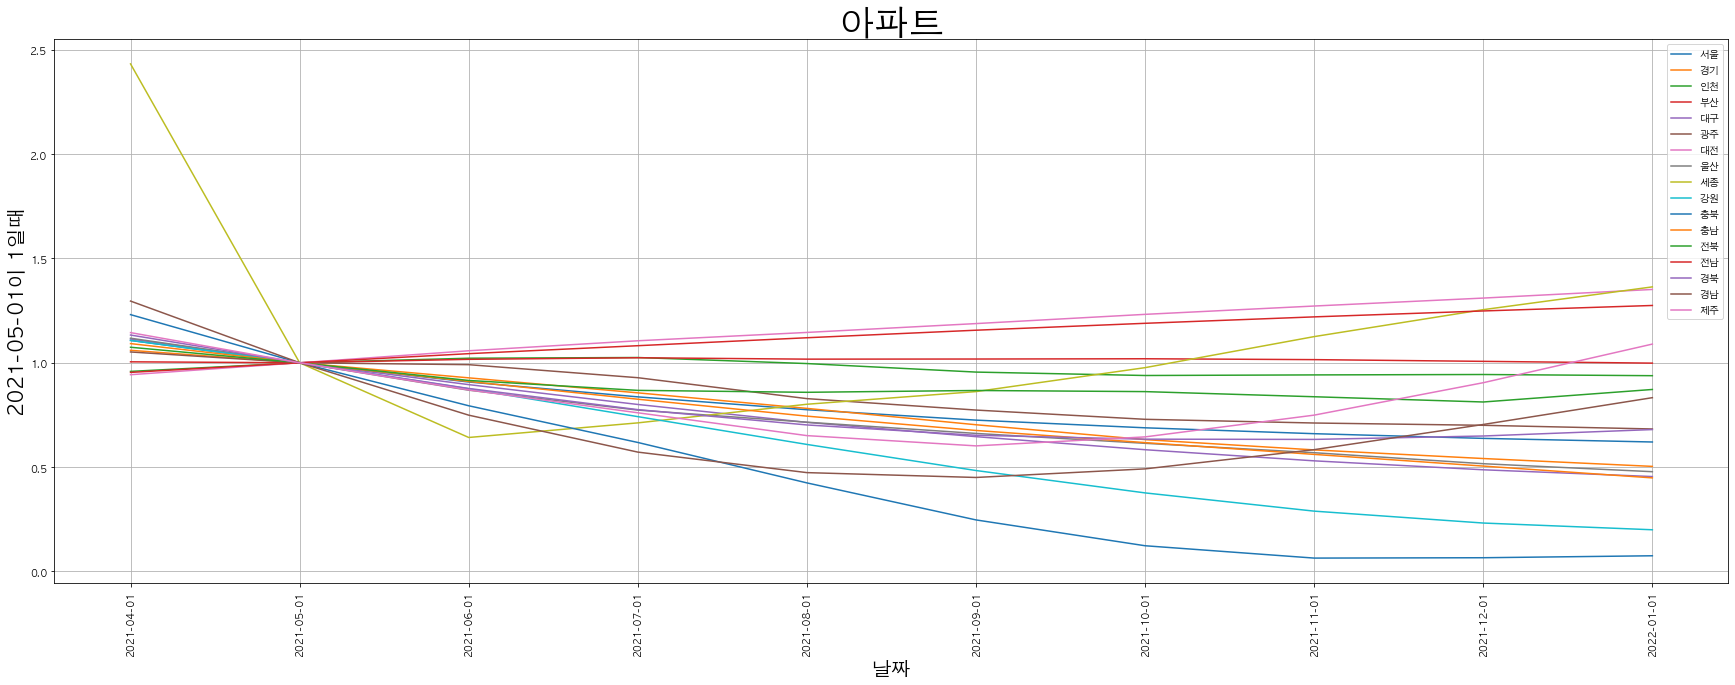

In [ ]:
df_to_line_graph(typeL[0].iloc[-10:],titles[0],"2021-05-01이 1일때")

### 3.2.2 연립다세대

In [ ]:
y_error=pd.read_csv("test/연립다세대_error.csv")
y_error

,지역,regression,machineLearning,deepLearning
0,서울,0.012134,0.028297,0.186225
1,경기,0.009273,0.138169,0.374002
2,인천,0.023312,0.073000,0.389047
3,부산,0.005640,0.108767,0.309484
4,대구,0.013974,0.067802,0.186868
5,광주,0.002465,0.006705,0.121592
6,대전,0.032292,0.061994,0.103030
7,울산,0.013662,0.076909,0.442477
8,세종,0.003754,0.038978,0.178817
9,강원,0.002991,0.165339,0.389830


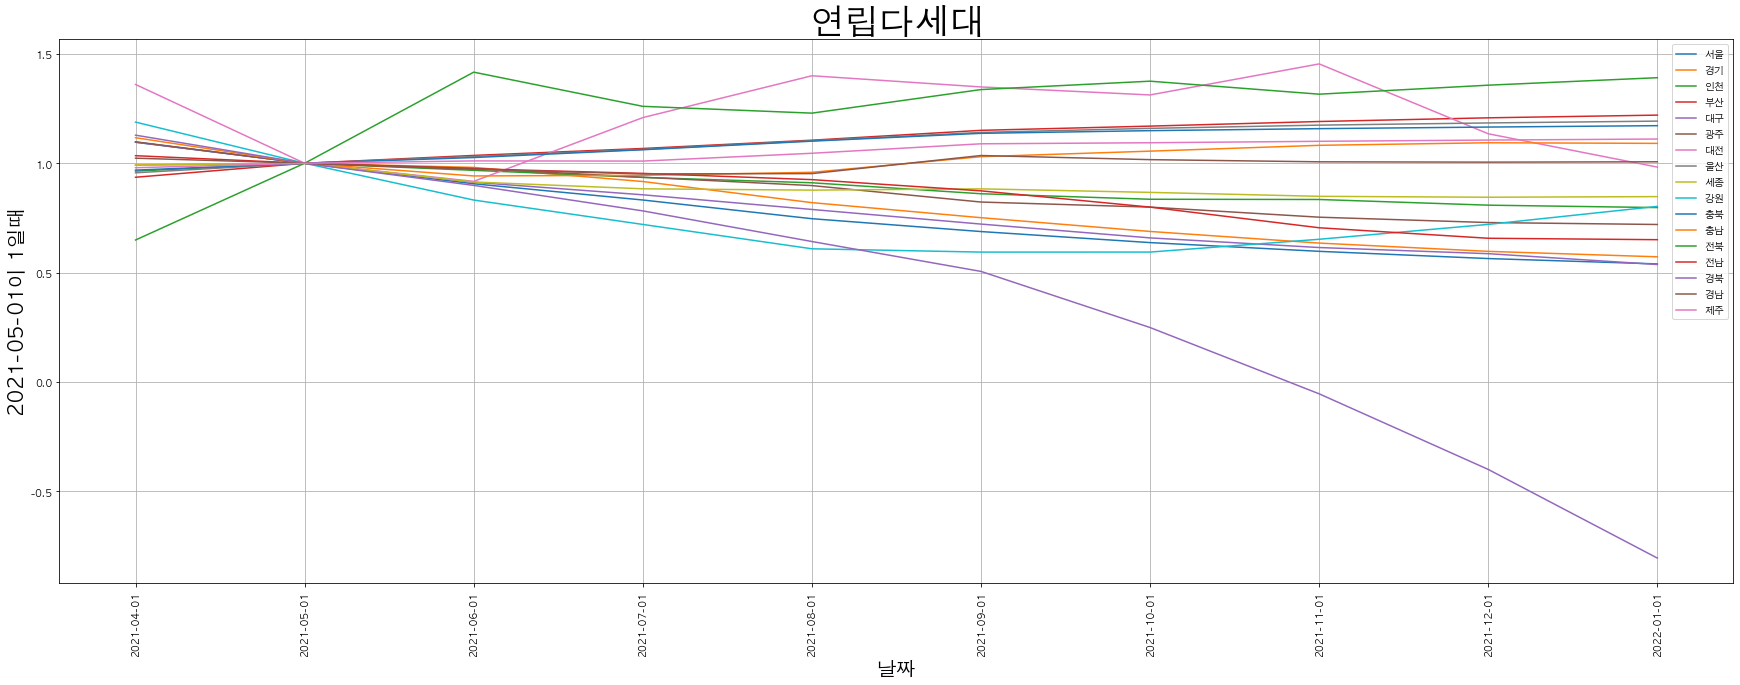

In [ ]:
df_to_line_graph(typeL[1].iloc[-10:],titles[1],"2021-05-01이 1일때")

### 3.2.3 단독주택

In [ ]:
house_error=pd.read_csv("test/단독주택_error.csv")
house_error

,지역,regression,machineLearning,deepLearning
0,서울,0.035144,0.060562,0.141172
1,경기,0.013673,0.031399,0.128425
2,인천,0.025338,0.187967,0.277258
3,부산,0.010793,0.122405,0.226839
4,대구,0.002999,0.004192,0.601818
5,광주,0.003286,0.008496,0.361022
6,대전,0.003373,0.007404,0.105074
7,울산,0.000805,0.064560,0.290770
8,세종,0.006708,0.014801,0.189793
9,강원,0.005485,0.038869,0.162728


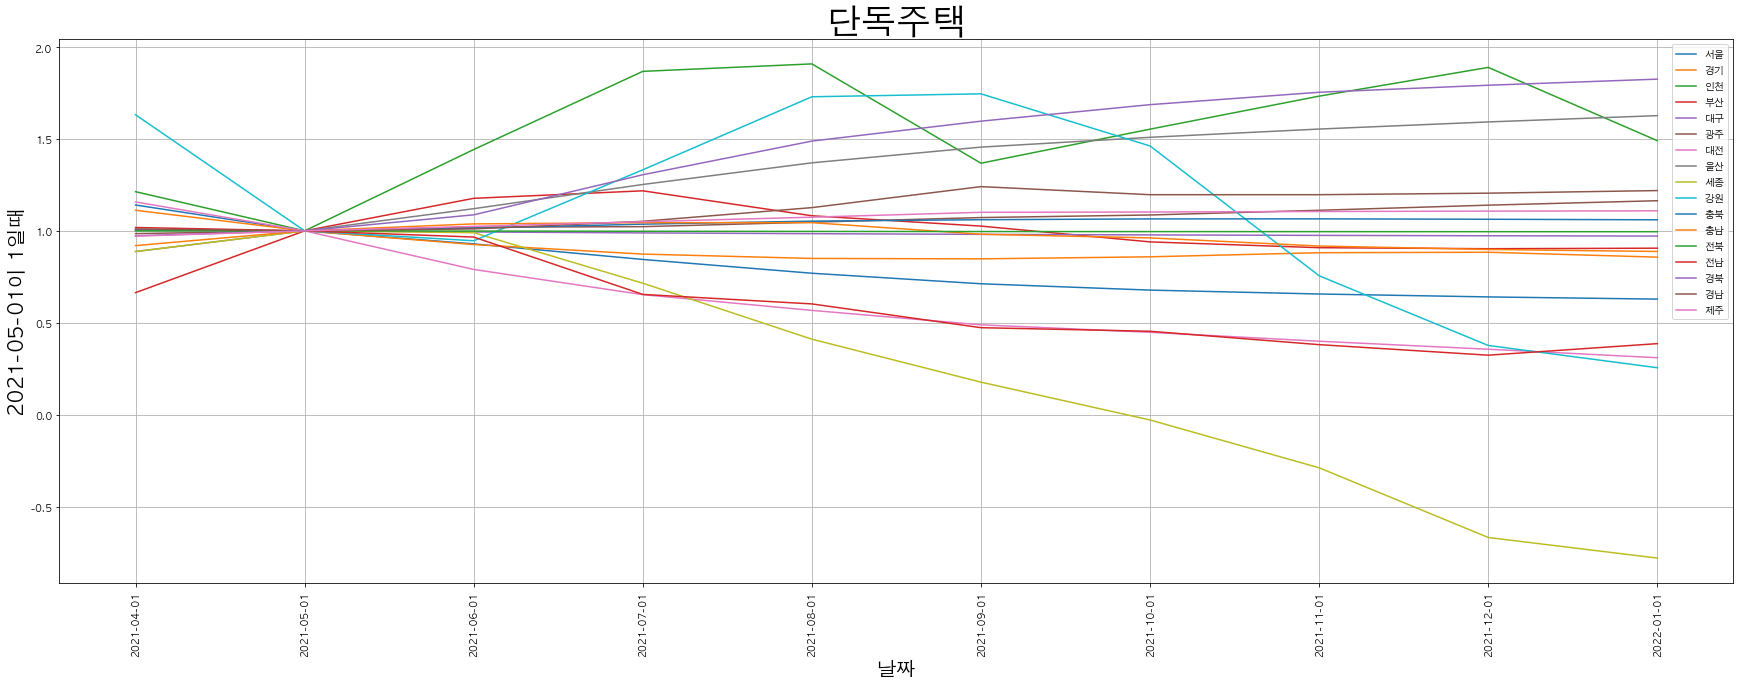

In [ ]:
df_to_line_graph(typeL[2].iloc[-10:],titles[2],"2021-05-01이 1일때")

## 3.3 최대상승 예상 지역 시각화
2022년 1월의 예측가격을 시각화합니다.  
y축은 2021년 5월의 가격을 1(가로선)이라고 할 때 2022년 1월의 가격을 의미합니다.  
즉 현재 집을 샀을 때 내년초에 집값이 어떻게 될지 지역별로 시각화 한것입니다.

<span style="color:red">빨간색</span>이 2021년 5월 대비 가장 상승할것으로 예측되는 가격,  
<span style="color:brown">갈색</span>이 2021년 5월 대비 가장 하락할것으로 예측되는 가격입니다.

### 3.3.1 아파트

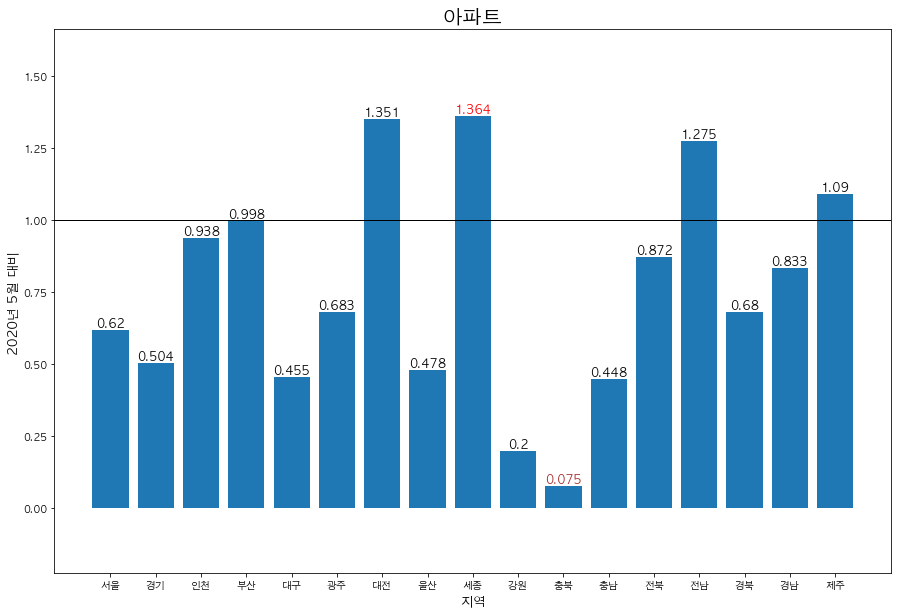

In [ ]:
to_bar_chart(list(typeL[0].columns),list(typeL[0].iloc[-1]),titles[0])

지금 아파트를 산다면 내년 1월에 세종 지역의 집값이 가장 높고 충북 지역의 집값이 가장 낮을 것으로 예상됩니다.

### 3.3.2 연립다세대

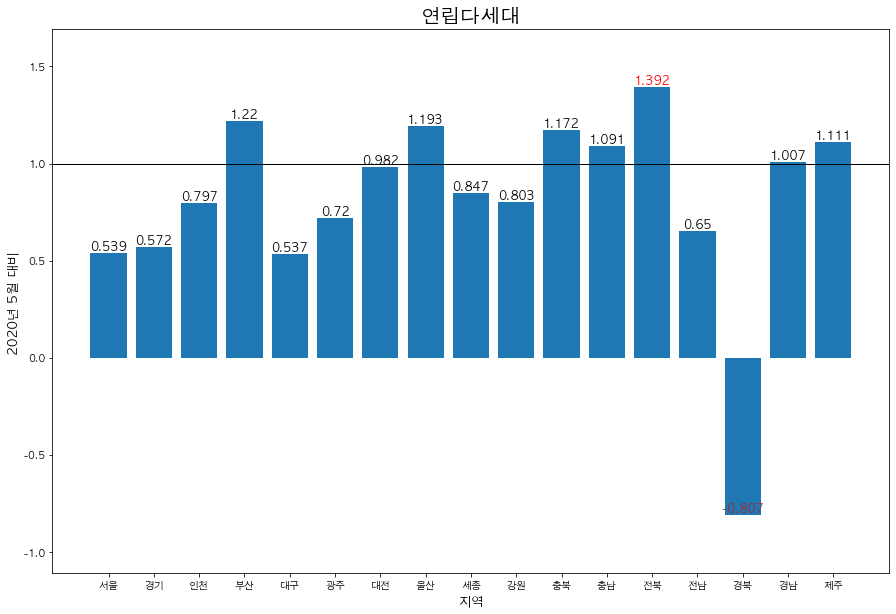

In [ ]:
to_bar_chart(list(typeL[1].columns),list(typeL[1].iloc[-1]),titles[1])

연립다세대의 경우는 내년 1월에 전북 지역의 집값이 가장 높고 경북지역의 집값이 가장 낮을 것으로 예상됩니다.

### 3.3.3 단독주택

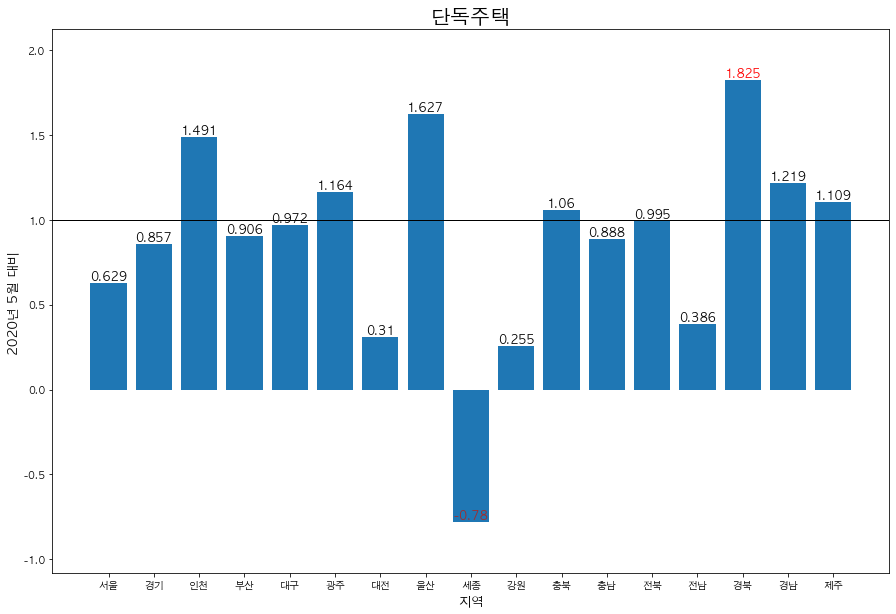

In [ ]:
to_bar_chart(list(typeL[2].columns),list(typeL[2].iloc[-1]),titles[2])

단독주택 경우는 내년 1월에 전남 지역의 집값이 가장 높고 울산지역의 집값이 가장 낮을 것으로 예상됩니다.단독주택 경우는 내년 1월에 경북 지역의 집값이 가장 높고 세종 지역의 집값이 가장 낮을 것으로 예상됩니다.

# 4. 실제 투자하기

그렇다면 실제 얼마를 투자하고 얼마를 벌 수 있는지 "부동산통계정보"에서 제공하는 아파트 데이터를 이용하여 알아보겠습니다.  

## 4.1 필요한 금액
아파트를 기준으로 세종시의 (월세통합)가격이 가장 상승할것으로 예측이 되었습니다.  
즉 돈을 벌기 위해선 세종시의 아파트를 사야겠지요??  

그렇다면 최근 세종시의 실제 집값과 추이를 통해 집을 사기위해 얼마가 필요한지 알아보겠습니다.  
데이콘에서 주어진 아파트 매매가격 데이터는 2019년 1월 데이터를 기준으로 **상대지수**의 형태로 나와있습니다.  
따라서 저는 **실제 가격**을 알아보기위해 "부동산통계정보" 사이트에서 제공하는 세종시 집값 데이터를 이용하였습니다.  

,가격
2020년 05월,3.95270
2020년 06월,4.04208
2020년 07월,4.28049
2020년 08월,4.66470
2020년 09월,4.85048
2020년 10월,4.90528
2020년 11월,4.95104
2020년 12월,4.99069
2021년 01월,5.02059
2021년 02월,5.04250


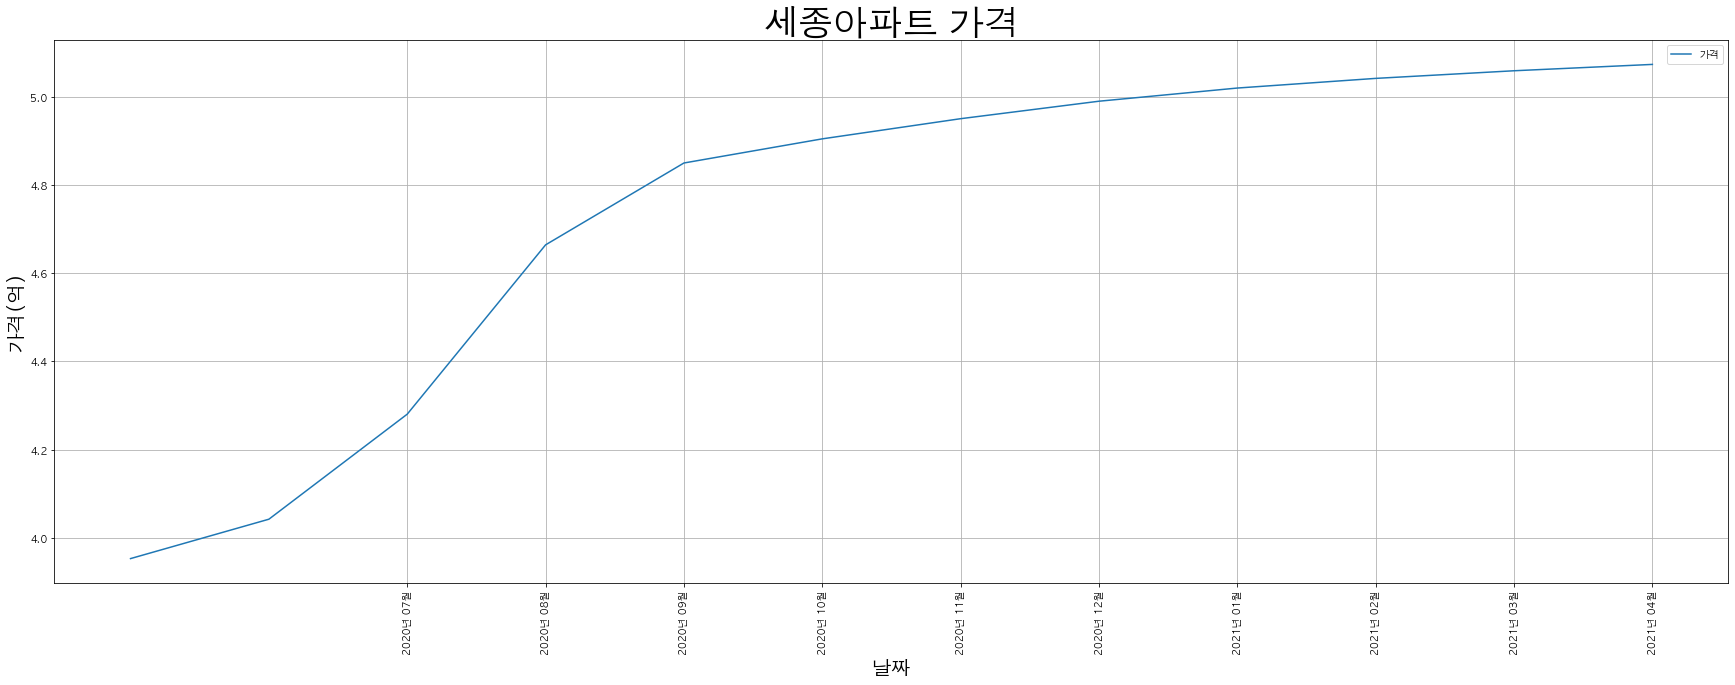

In [ ]:
sejong_apart=pd.read_csv("test/세종시_아파트.csv")
sejong_apart=sejong_apart.T[1:][[0]]
sejong_apart.columns=["가격"]
sejong_apart["가격"]=sejong_apart["가격"]/100000
display(sejong_apart)

df_to_line_graph(sejong_apart,"세종아파트 가격","가격(억)")

세종시 아파트 가격은 2020년 7월에서 9월까지 급격하게 올라 현재 평균 5억 7백만원정도 입니다.  

* 출처 : 부동산통계정보(https://www.r-one.co.kr/rone/resis/common/main/main.do)  
    
그렇다면 얼마를 벌 수 있을까요??  

## 4.2 예상 수익

앞서 예측한 아파트 가격은 월세 통합지수입니다.  
따라서 세종시의 실제 평균 아파트 월세가격과 추이를 알아보고 내년 1월에 얼마가 될 지 예측해 보겠습니다.  
월세가격 데이터 역시 "부동산통계정보" 사이트에서 제공하는 데이터를 활용하였습니다.  

,가격
2020년 05월,62.6
2020년 06월,62.7
2020년 07월,63.3
2020년 08월,63.8
2020년 09월,64.1
2020년 10월,64.7
2020년 11월,66.1
2020년 12월,68.6
2021년 01월,70.1
2021년 02월,70.5


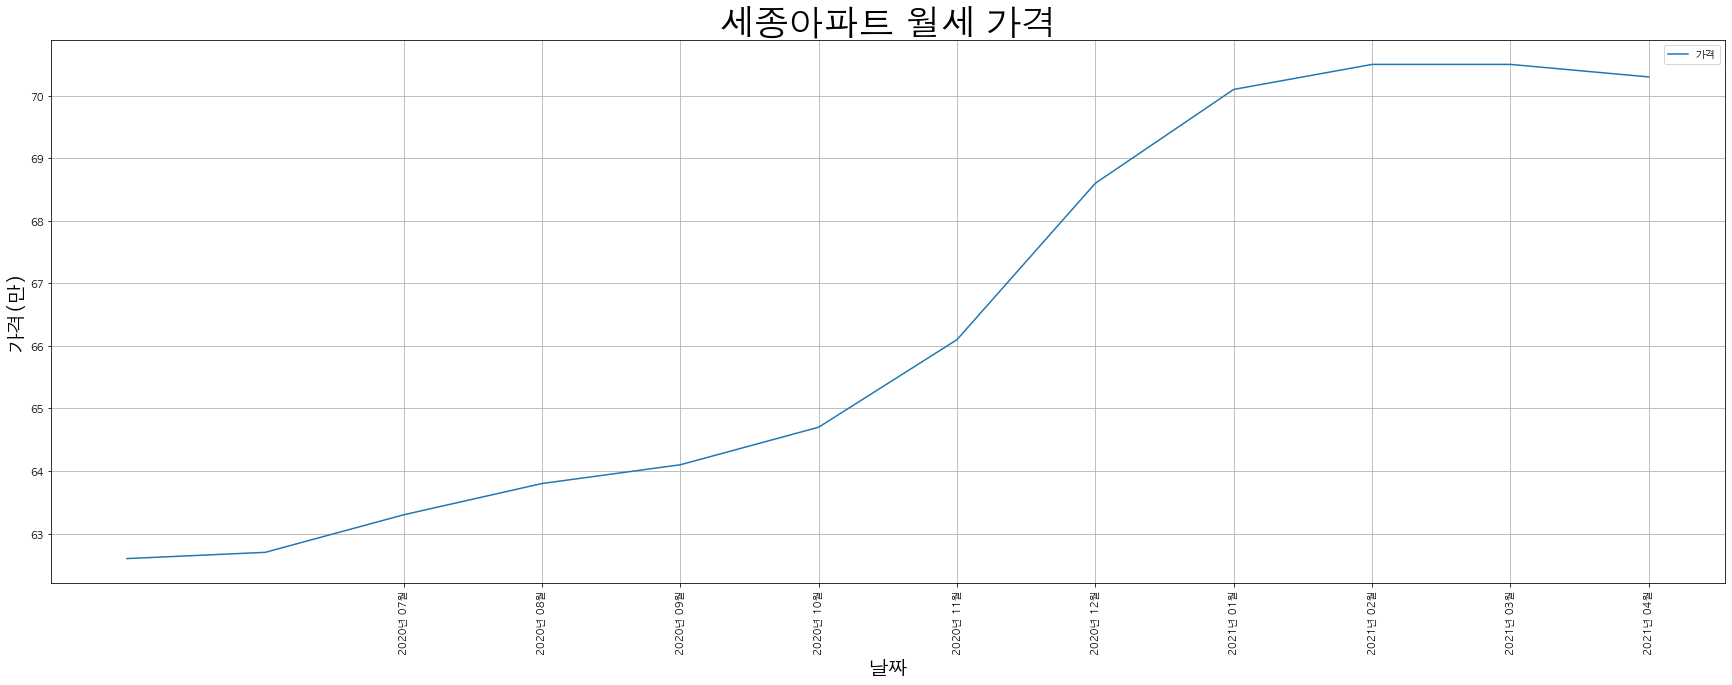

In [ ]:
sejong_daily=pd.read_csv("test/세종시_월세.csv")
sejong_daily=sejong_daily.T[1:][[0]]
sejong_daily.columns=["가격"]
sejong_daily["가격"]=sejong_daily["가격"]/10

display(sejong_daily)
df_to_line_graph(sejong_daily,"세종아파트 월세 가격","가격(만)")

월세가격은 2020년 7월부터 10월까지 꾸준히 오르다가 평균 약 70만원을 유지하고 있습니다.  
그리고 이 월세가격은 내년 1월에 1.364배 증가할것으로 예측되었습니다.  

즉 세종시의 내년 1월 월세가격은 **70.3*1.364=94.7만원**으로 예측됩니다.

# 5. 결론 및 한계

아파트를 사고싶다면 **세종**, 연립다세대를 산다면 **전북**, 단독주택을 산다면 **경북**에서 사는것이 가장 이득일 것으로 예측되었습니다.  

하지만 신입사원 평균 연봉이 **3382만원(2020년, 취업포탈 인크루트)**인 우리나라에서  
(아파트기준) 수익성이 가장 높을것으로 예상되는 세종의 **5억**짜리 아파트를 사는것이 가능한 것인가 하는 회의적인 생각이 들었습니다.  
서울의 집값은 당연히 이보다 더 높을 것이구요.  

분석을 하며 어짜피 집은 못사니 남는 돈으로 주식이나 비트코인에 투자하는 mz세대의 투자패턴이 이해가 되기도 했습니다.  
좋은 정책들이 나와서 부동산 가격이 안정되고 제가한 분석들이 의미있어지는 날이 왔으면 좋겠습니다.  

다양한 모델과 앙상블 기법을 이용하여 나름 높은 정확도를 달성하고 오버피팅을 방지하기위해 노력했습니다.  
하지만 지역별 예측한 가격들의 정확도가 조금 떨어져 보이는 느낌이 들어서 아쉬웠습니다.  
그래도 시각화 대회인 만큼 시각적인 부분도 완성도있게 구성하기 위해 노력했습니다.   
이러한 부분들을 많이 봐주셨으면 좋겠고, 제가 고민했던 부분들이 보신 분들께 조금이라도 도움이 되었으면 좋겠습니다.  

많은 도움이 되셨길 바랍니다!  

감사합니다!    